In [1]:
!pip install tensorflow
!pip install numpy

In [23]:
!pip install keras_vggface
!pip install keras_applications
!pip install mtcnn

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt 

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, FalseNegatives, FalsePositives, TrueNegatives, TruePositives, AUC
from tensorflow.math import confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image
from tqdm import tqdm
from mtcnn.mtcnn import MTCNN
#from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.layers import Layer, InputSpec
import tensorflow.python.keras.engine
from tensorflow.keras import Model
from keras.layers import Input
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

In [2]:
TRAINING_DIR = r"E:\deepfake\deepfake_resnet50\Dataset\Train"
TEST_DIR = r"E:\deepfake\deepfake_resnet50\Dataset\Test"
VALIDATION_DIR = r"E:\deepfake\deepfake_resnet50\Dataset\Validation"

print(f'Total training images REAL: {len(os.listdir(os.path.join(TRAINING_DIR, "real")))}')
print(f'Total training images FAKE: {len(os.listdir(os.path.join(TRAINING_DIR, "fake")))}\n')

print(f'Total test images REAL: {len(os.listdir(os.path.join(TEST_DIR, "real")))}')
print(f'Total test images FAKE: {len(os.listdir(os.path.join(TEST_DIR, "fake")))}\n')

print(f'Total test images REAL: {len(os.listdir(os.path.join(VALIDATION_DIR, "real")))}')
print(f'Total test images FAKE: {len(os.listdir(os.path.join(VALIDATION_DIR, "fake")))}')

Total training images REAL: 50001
Total training images FAKE: 50001

Total test images REAL: 5413
Total test images FAKE: 5492

Total test images REAL: 15001
Total test images FAKE: 15001


In [3]:
training_datagen = ImageDataGenerator(
    rescale=1./255,
    #validation_split=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

img_size = 300
img_batch = 32

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    subset='training',
    target_size=(img_size, img_size),
    shuffle=True,
    class_mode='binary',
    batch_size=img_batch
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    #subset='validation',
    target_size=(img_size, img_size),
    shuffle=True,
    class_mode='binary',
    batch_size=img_batch
)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(img_size, img_size),
    class_mode='binary',
    batch_size=img_batch,
    shuffle=False
)

Found 100002 images belonging to 2 classes.
Found 30002 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


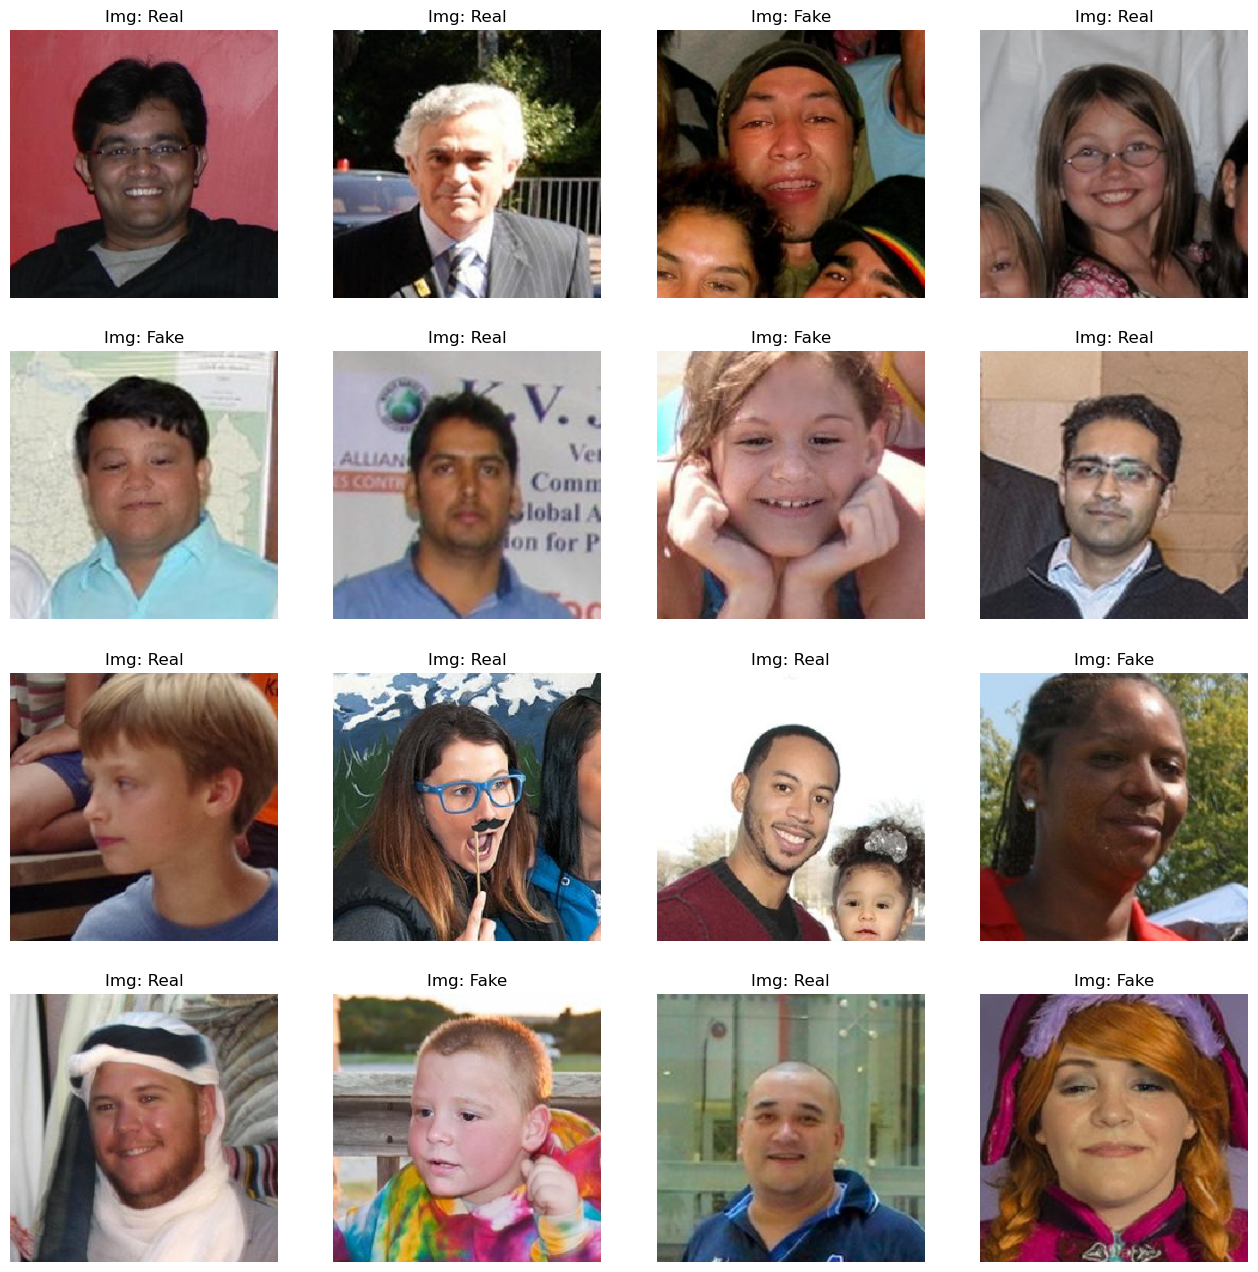

In [27]:
labels = {1.0: 'Real', 0.0: 'Fake'}

for images, images_labels in train_generator:
    plt.figure(figsize=(16, 16))
    
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.title(f'Img: {labels[images_labels[i]]}')
        plt.imshow(np.uint8(255 * images[i]))
        plt.axis('off')
    break

In [17]:
model = Sequential([

    Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN
    Flatten(),

    # 384 neuron hidden layer
    Dense(384, activation='relu'),

    # Only 1 output neuron. It will contain a value from 0-1 where 0 identifies a fake face and 1 a real face
    Dense(1, activation='sigmoid')

])

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

callback = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model1.hdf5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=25,
    validation_data=validation_generator,
    verbose=1,
    callbacks=callback
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 149, 149, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 35, 35, 64)      

25/25 [==============================] - 487s 20s/step - loss: 0.4684 - accuracy: 0.7700 - val_loss: 0.5383 - val_accuracy: 0.7244
Epoch 21/50
25/25 [==============================] - ETA: 0s - loss: 0.4733 - accuracy: 0.7650
Epoch 21: val_loss improved from 0.53829 to 0.52964, saving model to model1.hdf5
25/25 [==============================] - 483s 20s/step - loss: 0.4733 - accuracy: 0.7650 - val_loss: 0.5296 - val_accuracy: 0.7330
Epoch 22/50
25/25 [==============================] - ETA: 0s - loss: 0.4286 - accuracy: 0.8125
Epoch 22: val_loss did not improve from 0.52964
25/25 [==============================] - 1616s 67s/step - loss: 0.4286 - accuracy: 0.8125 - val_loss: 0.5531 - val_accuracy: 0.7193
Epoch 23/50
25/25 [==============================] - ETA: 0s - loss: 0.4332 - accuracy: 0.8037
Epoch 23: val_loss improved from 0.52964 to 0.52521, saving model to model1.hdf5
25/25 [==============================] - 319s 13s/step - loss: 0.4332 - accuracy: 0.8037 - val_loss: 0.5252 - v

Epoch 49/50
25/25 [==============================] - ETA: 0s - loss: 0.4143 - accuracy: 0.8075
Epoch 49: val_loss did not improve from 0.46172
25/25 [==============================] - 374s 16s/step - loss: 0.4143 - accuracy: 0.8075 - val_loss: 0.4619 - val_accuracy: 0.7789
Epoch 50/50
25/25 [==============================] - ETA: 0s - loss: 0.3648 - accuracy: 0.8338
Epoch 50: val_loss did not improve from 0.46172
25/25 [==============================] - 483s 20s/step - loss: 0.3648 - accuracy: 0.8338 - val_loss: 0.4661 - val_accuracy: 0.7769


In [5]:
model = Sequential([

    Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN
    Flatten(),

    # 384 neuron hidden layer
    Dense(384, activation='relu'),

    # Only 1 output neuron. It will contain a value from 0-1 where 0 identifies a fake face and 1 a real face
    Dense(1, activation='sigmoid')

])

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

callback = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model1.hdf5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    train_generator,
    epochs=25,
    steps_per_epoch=30,
    validation_data=validation_generator,
    verbose=1,
    callbacks=callback
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [5]:
model = Sequential([

    Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN
    Flatten(),

    # 384 neuron hidden layer
    Dense(384, activation='relu'),

    # Only 1 output neuron. It will contain a value from 0-1 where 0 identifies a fake face and 1 a real face
    Dense(1, activation='sigmoid')

])

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

callback = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model1.hdf5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    train_generator,
    epochs=5,
    steps_per_epoch=100,
    validation_data=validation_generator,
    verbose=1,
    callbacks=callback
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [6]:
model = Sequential([

    Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN
    Flatten(),

    # 384 neuron hidden layer
    Dense(384, activation='relu'),

    # Only 1 output neuron. It will contain a value from 0-1 where 0 identifies a fake face and 1 a real face
    Dense(1, activation='sigmoid')

])

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

callback = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model1.hdf5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    train_generator,
    epochs=15,
    steps_per_epoch=100,
    validation_data=validation_generator,
    verbose=1,
    callbacks=callback
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 35, 35, 64)      

In [6]:
model = Sequential([

    Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN
    Flatten(),

    # 384 neuron hidden layer
    Dense(384, activation='relu'),

    # Only 1 output neuron. It will contain a value from 0-1 where 0 identifies a fake face and 1 a real face
    Dense(1, activation='sigmoid')

])

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

callback = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model1.hdf5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=100,
    validation_data=validation_generator,
    verbose=1,
    callbacks=callback
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [ ]:
plt.figure(figsize=(25, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')


In [ ]:

metrics = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
index_model_checkpoint = np.argmin(history.history['val_loss'])
[f'Best {metric}: {history.history[metric][index_model_checkpoint]:.2f}' for metric in metrics]

In [6]:
def load_and_test_model(model_name, test_generator, display_model_summary=False):
    try:
        loaded_model = tf.keras.models.load_model(f'{model_name}.hdf5')
    except OSError:
        print('The model called does not exist. Testing for the last saved model.')
        loaded_model = tf.keras.models.load_model('model1.hdf5')
    if display_model_summary:
        loaded_model.summary()
    test_loss, test_acc = loaded_model.evaluate(test_generator)
    print(f'Test loss: {round(test_loss, 2)}, Test accuracy: {round(test_acc * 100, 2)}')

In [7]:
load_and_test_model('CNN_Base_8429', test_generator)

The model called does not exist. Testing for the last saved model.
341/341 [==============================] - 471s 1s/step - loss: 0.4591 - accuracy: 0.7808
Test loss: 0.46, Test accuracy: 78.08


In [8]:
def calculate_model_performance_metrics(model_name, test_dataset, transfer_ml=False, model_version=0,
                                        show_plots=False):
    
    try:
        loaded_model = tf.keras.models.load_model(f'{model_name}.hdf5')
        print(f'Calculating performance metrics for model {model_name}')
    except OSError:
        print('The model called does not exist. Testing for the last saved model.')
        loaded_model = tf.keras.models.load_model('model1.hdf5')

    if transfer_ml and model_version != 0:
        test_images, true_labels = test_dataset.as_numpy_iterator().next()
        test_images = utils.preprocess_input(test_images, version=model_version)
        predictions_sigmoid = loaded_model.predict(test_images, verbose=1)
    else:
        true_labels = test_dataset.labels
        predictions_sigmoid = loaded_model.predict(test_dataset, verbose=1)
    
    false_positives_negatives = []
    lower_bound_threshold = 0.2
    upper_bound_threshold = 0.7
    step = 0.001

    sigmoid_threshold = np.arange(lower_bound_threshold, upper_bound_threshold, step)

    for threshold in sigmoid_threshold:
        predictions_binary = tf.where(predictions_sigmoid > threshold, 1, 0)
        conf_matrix = confusion_matrix(true_labels, predictions_binary)
        false_positives_negatives.append(conf_matrix[0][1] + conf_matrix[1][0])

    min_threshold = sigmoid_threshold[np.argmin(false_positives_negatives)]
    print(f'Minimizer of false positives and false negatives: {min_threshold:.3f}')

    metrics_options = {
        'Precision': Precision,
        'Recall': Recall,
        'True Positives': TruePositives,
        'True Negatives': TrueNegatives,
        'False Positives': FalsePositives,
        'False Negatives': FalseNegatives
    }

    def disp_metrics(metric, threshold_value=min_threshold, verbose=False):
        metrics = metrics_options[metric](thresholds=threshold_value)
        metrics.update_state(true_labels, predictions_sigmoid)
        result = metrics.result().numpy()
        if verbose:
            print(f'{metric}: {result:.3f}')
        return result

    bin_acc = BinaryAccuracy(threshold=min_threshold)
    bin_acc.update_state(true_labels, predictions_sigmoid)
    print(f'Binary Accuracy: {bin_acc.result().numpy():.3f}')

    for metric in metrics_options.keys():
        disp_metrics(metric, verbose=True)

    rights = disp_metrics('True Positives') + disp_metrics('True Negatives')
    wrongs = disp_metrics('False Positives') + disp_metrics('False Negatives')
    print(f'Number of right guesses: {rights:.3f}')
    print(f'Number of wrong guesses: {wrongs:.3f}')

    auc = AUC()
    auc.update_state(true_labels, predictions_sigmoid)
    auc = auc.result().numpy()
    print(f'Area under curve ROC: {auc:.3f}')

    precision = disp_metrics('Precision')
    recall = disp_metrics('Recall')

    f1_score = 2 * (precision * recall) / (precision + recall)
    print(f'F1-Score: {f1_score:.3f}')


    if show_plots:
        
        plt.figure(figsize=(18, 14))
    
        plt.subplot(2, 2, 1)
        plt.plot(sigmoid_threshold, false_positives_negatives, linewidth=3)
        plt.title('Sum of false positives and false negatives as a function of sigmoid threshold')
        plt.xlabel('Sigmoid threshold')
        plt.ylabel('False positives + False negatives')

        plt.subplot(2, 2, 2)
        cm = confusion_matrix(true_labels, tf.where(predictions_sigmoid > min_threshold, 1, 0))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title(f'Confusion matrix @{min_threshold:.3f}')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')

        plt.subplot(2, 2, 3)
        false_positive_rate, true_positive_rate, _ = roc_curve(true_labels, predictions_sigmoid)
        plt.plot(false_positive_rate, true_positive_rate, linewidth=4)
        plt.title(f'Receiver Operating Characteristic curve for AUC: {auc:.3f}')
        plt.xlabel('False positive rate')
        plt.ylabel('True positives rate')
        plt.grid(True)

        plt.subplot(2, 2, 4)
        prec, rec, _ = precision_recall_curve(true_labels, predictions_sigmoid)
        plt.plot(rec, prec, linewidth=4)
        avg_precision_score = average_precision_score(true_labels, predictions_sigmoid)
        plt.title(f'Precision-Recall curve | Average precision score: {avg_precision_score:.3f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.grid(True)
    
    return min_threshold

The model called does not exist. Testing for the last saved model.
341/341 [==============================] - 229s 669ms/step
Minimizer of false positives and false negatives: 0.445
Binary Accuracy: 0.785
Precision: 0.775
Recall: 0.797
True Positives: 4315.000
True Negatives: 4241.000
False Positives: 1251.000
False Negatives: 1098.000
Number of right guesses: 8556.000
Number of wrong guesses: 2349.000
Area under curve ROC: 0.866
F1-Score: 0.786


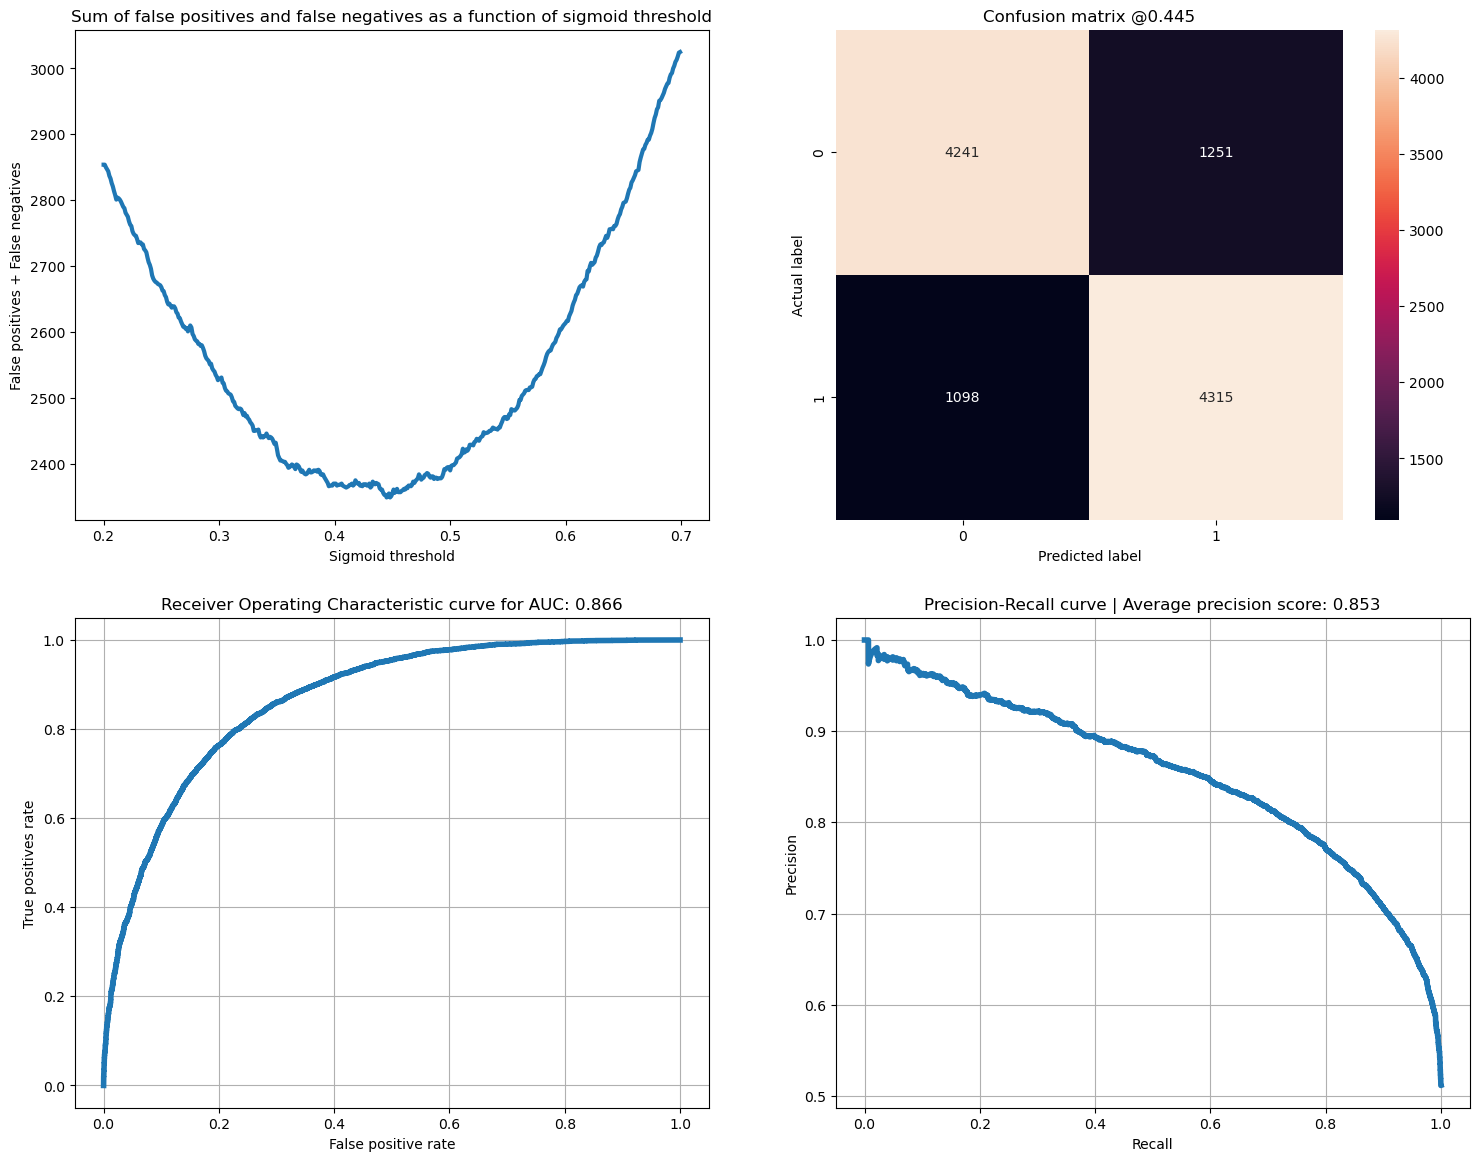

In [9]:
min_threshold = calculate_model_performance_metrics('CNN_Base_8429', test_generator, show_plots=True)

Found 10905 images belonging to 2 classes.
1/1 [==============================] - 1s 720ms/step


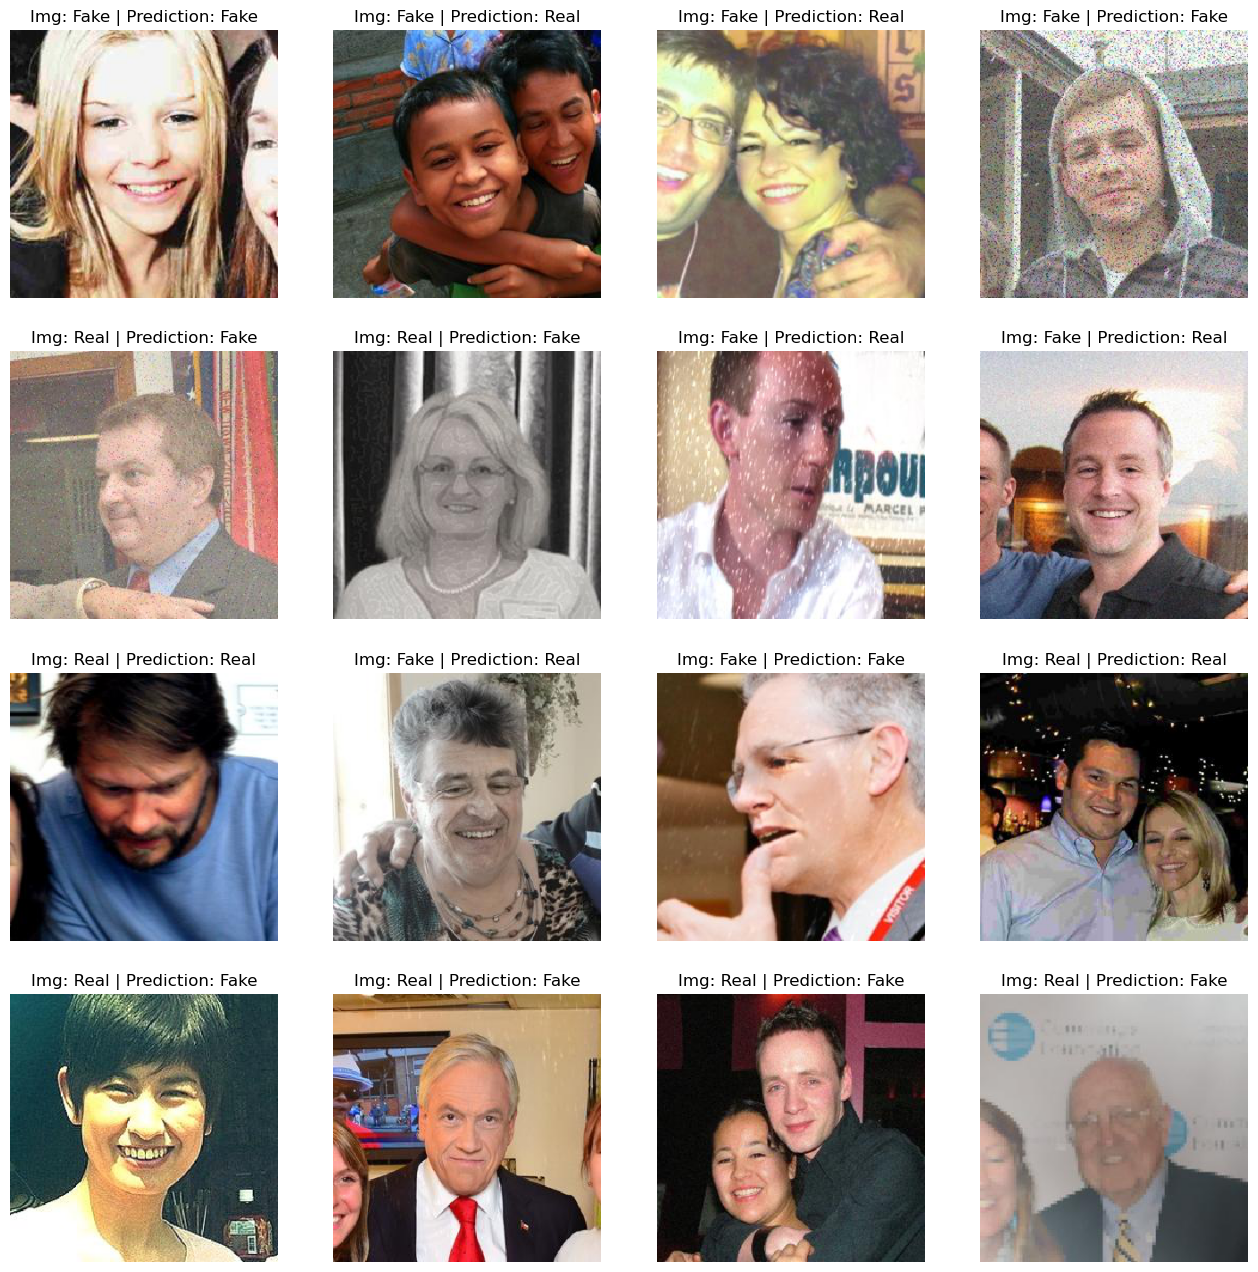

In [10]:
labels = {1.0: 'Real', 0.0: 'Fake'}

test_generator = test_datagen.flow_from_directory(TEST_DIR, target_size=(img_size, img_size), class_mode='binary')
loaded_model = tf.keras.models.load_model('model.hdf5')

for images, images_labels in test_generator:
    plt.figure(figsize=(16, 16))
    predictions = tf.where(loaded_model.predict(images) > min_threshold, 1, 0)
    predictions = tf.reshape(predictions, [-1]).numpy()

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.title(f'Img: {labels[images_labels[i]]} | Prediction: {labels[predictions[i]]}')
        plt.imshow(np.uint8(255 * images[i]))
        plt.axis('off')
    break
